In [14]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter
import re
import pyproj

In [4]:
datapath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5'

In [5]:
!h5ls -r /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

In [25]:
with h5py.File(datapath, 'r') as f:
    segment_id = f['/gt2l/land_ice_segments/segment_id'][:]
print(segment_id)
# /gt2l/land_ice_segments/segment_id

[1450950 1450951 1450952 ... 1456628 1456629 1456630]


In [33]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
        D['data_start_utc'] = h5f['/ancillary_data/data_start_utc'][:]
        D['delta_time'] = h5f['/gt2l/land_ice_segments/delta_time'][:]

    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

In [34]:
ATL06_track = atl06_to_dict(datapath, 'gt2l', epsg=3031)

In [29]:
ATL06_track.keys()

dict_keys(['latitude', 'longitude', 'h_li', 'atl06_quality_summary', 'x_atc', 'y_atc', 'dh_fit_dx', 'dh_fit_dy', 'data_start_utc', 'x', 'y', 'rgt', 'cycle', 'beam'])

[60260046.62119763 60260046.6240197  60260046.62684182 ...
 60260062.62573686 60260062.62856199 60260062.63138753]
[b'2019-11-29T10:53:45.845255Z']


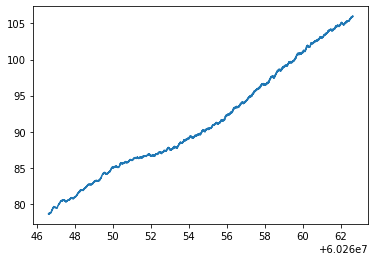

In [42]:
print(ATL06_track['delta_time'])
print(ATL06_track['data_start_utc'])

plt.plot(ATL06_track['delta_time'], ATL06_track['h_li'])
# plt.scatter(ATL06_track['x'],ATL06_track['y'],1,ATL06_track['h_li'])
# plt.colorbar()

Try fittopo.py

In [48]:
timevector = ATL06_track['delta_time'] - ATL06_track['delta_time'][0]
import datetime
# logic: turn into decimal years, somehow

AttributeError: module 'datetime' has no attribute 'strptime'

In [22]:
!python fittopo.py -h

usage: fittopo.py [-h] [-d dx dy] [-r radius] [-q n_reloc] [-i n_iter]
                  [-z min_obs] [-m mod_lim] [-k mod_order] [-t ref_time]
                  [-j epsg_num] [-v x y t h] [-x expr] [-n n_jobs]
                  [-s slope_lim] [-p]
                  file [file ...]

Compute surface elevation residuals from satellite/airborne altimetry.

positional arguments:
  file          file(s) to process (HDF5)

optional arguments:
  -h, --help    show this help message and exit
  -d dx dy      spatial resolution for grid-solution (deg or km)
  -r radius     min and max search radius (km)
  -q n_reloc    number of relocations for search radius
  -i n_iter     maximum number of iterations for model solution
  -z min_obs    minimum obs to compute solution
  -m mod_lim    minimum obs for higher order models
  -k mod_order  order of the surface fit model: 1=lin or 2=quad
  -t ref_time   time to reference the solution to: year|fixed|variable
  -j epsg_num   projection: EPSG number (AnI

t_year is decimal years

In [ ]:
!python ./fittopo.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
-k 2 -t 2020 -j 3031 -v lon lat t_year h_li -s 10 -p

970